# Sistema de Recomendación basado en Reglas de Asociación
## Punto 2 — Machine Learning Project
**Dataset:** Amazon Reviews 2023
El dataset utilizado corresponde al conjunto Amazon Reviews 2023, específicamente la categoría Baby Products.
- El dataset NO se incluye directamente en este repositorio, pero puede ser descargado desde la fuente oficial: [Baby_Products.jsonl](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/blob/main/raw/review_categories/Baby_Products.jsonl) 

In [2]:
import json
import pandas as pd

def load_jsonl(path, limit=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

df = load_jsonl("./Baby_Products.jsonl")
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,Good buy for preschool naps and home use...,I bought two of these for my kids for nap time...,[],B004FM7VOW,B089MS68G8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471546337000,1,True
1,5.0,THEY WORK- and are super cute to boot...,LOVE THESE! AND THEY WORK!!! I was on the fenc...,[],B01E5E703G,B01E5E703G,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471542244000,1,True
2,1.0,cute but small and pretty much unusable as a c...,cute but small and pretty much unusable as a c...,[],B00F463XV8,B00F9386Q8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1452650881000,0,True
3,5.0,Works great perfect size!,I have lots of different disposable diaper bag...,[],B0007V644S,B07RRDX26B,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1408994051000,0,True
4,5.0,Cute and Works Great,I was so excited for bath time when I register...,[],B002LARFLY,B00OLRJET6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1349818961000,0,False


C:\Users\jposp\AppData\Local\Temp\ipykernel_23988\511896884.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.index, y=top_items.values, palette="viridis")


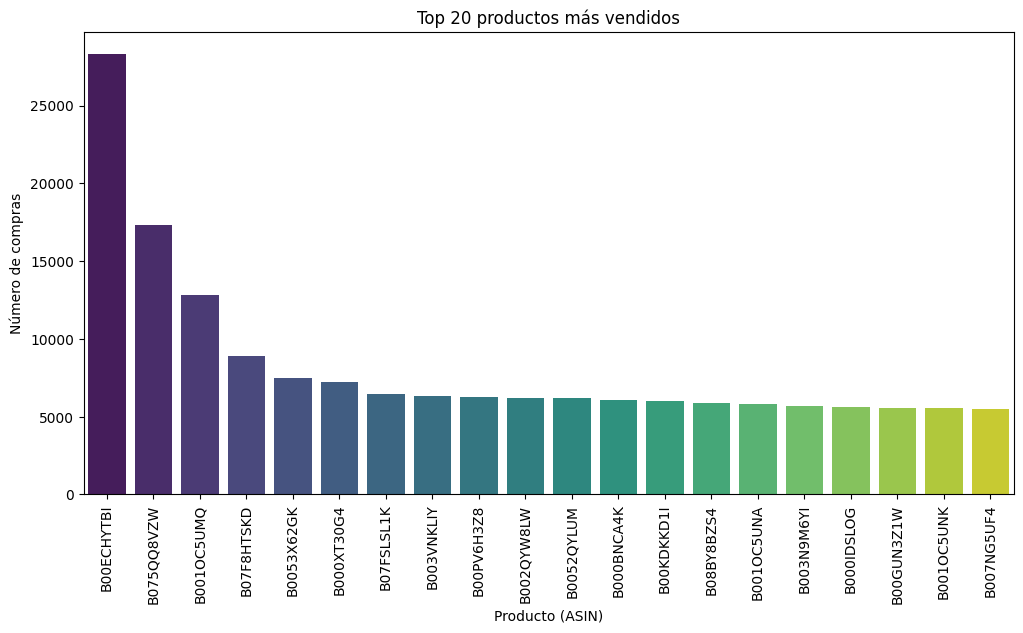

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

top_items = df['asin'].value_counts().head(20)  

plt.figure(figsize=(12,6))
sns.barplot(x=top_items.index, y=top_items.values, palette="viridis")
plt.xticks(rotation=90)  
plt.xlabel("Producto (ASIN)")
plt.ylabel("Número de compras")
plt.title("Top 20 productos más vendidos")
plt.show()


In [24]:
df[['rating', 'helpful_vote']].describe()



,rating,helpful_vote
count,6.028884e+06,6.028884e+06
mean,4.211133e+00,9.182690e-01
std,1.320397e+00,1.383124e+01
min,0.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,6.372000e+03


In [10]:
df2 = df[["user_id", "asin"]].dropna()
df2.columns = ["user", "item"]

In [11]:
user_counts = df2["user"].value_counts()
valid_users = user_counts[user_counts >= 2].index

df2 = df2[df2["user"].isin(valid_users)]
print(df2.shape)

(3685943, 2)


In [12]:
transactions = df2.groupby("user")["item"].apply(list)

print("Tipo:", type(transactions))
print("Usuarios encontrados:", len(transactions))
print("Primeras 5 transacciones:")
for t in transactions.head(5):
    print(t)

Tipo: <class 'pandas.core.series.Series'>
Usuarios encontrados: 1043265
Primeras 5 transacciones:
['B0027VT9IO', 'B001FB5JJK', 'B0007KPC60']
['B00477ND0Q', 'B004TYOJNW', 'B01DPH4A32', 'B005PY331O']
['B078K9F7RL', 'B00ERZ4AUA', 'B01BQLPIX0']
['B00A4B34IA', 'B075YW6V65', 'B01ABQBERA', 'B07NT4F8DG', 'B000RFCXIK', 'B01HP0681W', 'B07VNBWF3K', 'B07HCZ1CPD']
['B07NRSY1H5', 'B01LTHO2KQ']


In [13]:
import pandas as pd

transactions_df = pd.DataFrame({"items": transactions})
transactions_df.head()


,items
user,
AE22236AFRRSMQIKGG7TPTB75QEA,"[B0027VT9IO, B001FB5JJK, B0007KPC60]"
AE2223EZBHNIO5LHPKDLXBL3IMQQ,"[B00477ND0Q, B004TYOJNW, B01DPH4A32, B005PY331O]"
AE222DC56L5YZZGBA5LKSOI7PQTQ,"[B078K9F7RL, B00ERZ4AUA, B01BQLPIX0]"
AE222ELC2EMGPS4KSGXKMSFZTOYA,"[B00A4B34IA, B075YW6V65, B01ABQBERA, B07NT4F8D..."
AE222SLWUZXBLZNQIYYYNEVIEJ4Q,"[B07NRSY1H5, B01LTHO2KQ]"


In [14]:
item_counts = df2["item"].value_counts()
frequent_items = item_counts[item_counts >= 400].index

filtered_transactions = [
    [item for item in t if item in frequent_items]
    for t in transactions
]
filtered_transactions = [t for t in filtered_transactions if len(t) > 0]

print("Items finales:", len(frequent_items))


Items finales: 1138


In [28]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_matrix = te.fit(filtered_transactions).transform(filtered_transactions)
df_onehot = pd.DataFrame(te_matrix, columns=te.columns_)
print(df_onehot)

        B00002JV9S  B00003TL7P  B000046S3W  B000056HMB  B000056JMU  \
0            False       False       False       False       False   
1            False       False       False       False       False   
2            False       False       False       False       False   
3            False       False       False       False       False   
4            False       False       False       False       False   
...            ...         ...         ...         ...         ...   
583261       False       False       False       False       False   
583262       False       False       False       False       False   
583263       False       False       False       False       False   
583264       False       False       False       False       False   
583265       False       False       False       False       False   

        B000056OUO  B000056OV0  B00005BTNA  B00005BXKM  B00006408K  ...  \
0            False       False       False       False       False  ...   
1        

In [17]:
import time
from mlxtend.frequent_patterns import fpgrowth


start = time.time()
frequent_itemsets = fpgrowth(df_onehot, min_support=0.0001, use_colnames=True)
end = time.time()

print("Tiempo:", end - start)
print(frequent_itemsets.head())


Tiempo: 342.1038386821747
    support      itemsets
0  0.001576  (B00ERZ4AUA)
1  0.002551  (B00A4B34IA)
2  0.002011  (B000RFCXIK)
3  0.000950  (B00099YJH2)
4  0.000938  (B07HC3M6CD)


In [18]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

print("Total reglas generadas:", len(rules))
rules.head()


Total reglas generadas: 6


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(B00ECI1JM4),(B00ECHYTBI),0.000938,0.022729,0.000492,0.524680,23.084261,1.0,0.000471,2.056028,0.957578,0.021233,0.513625,0.273165
1,(B009IWNPXK),(B009IVKY7Q),0.001413,0.002052,0.000629,0.445388,217.025799,1.0,0.000626,1.799363,0.996800,0.221886,0.444248,0.375994
2,(B009IVKY7Q),(B009IWNPXK),0.002052,0.001413,0.000629,0.306600,217.025799,1.0,0.000626,1.440131,0.997439,0.221886,0.305619,0.375994
3,(B00ECH5ARA),(B00ECHYTBI),0.001282,0.022729,0.000519,0.405080,17.822246,1.0,0.000490,1.642694,0.945102,0.022114,0.391244,0.213968
4,"(B00B9ZHQ5W, B009IWNPXK)",(B009IVKY7Q),0.000228,0.002052,0.000171,0.751880,366.370814,1.0,0.000171,4.022032,0.997498,0.081301,0.751369,0.417711


In [19]:
recommendation_dict = {}

for idx, row in rules.iterrows():
    antecedent = tuple(sorted(list(row["antecedents"])))
    consequent = list(row["consequents"])[0]

    if antecedent not in recommendation_dict:
        recommendation_dict[antecedent] = []

    recommendation_dict[antecedent].append({
        "item": consequent,
        "confidence": row["confidence"],
        "lift": row["lift"]
    })


In [20]:
def recommend(cart, rules_df, top_n=5):
    cart = set(cart)
    candidates = []

    for idx, row in rules_df.iterrows():
        antecedent = set(row["antecedents"])
        consequent = list(row["consequents"])[0]

        if antecedent.issubset(cart):
            candidates.append(
                (consequent, row["confidence"], row["lift"])
            )

    candidates = sorted(candidates, key=lambda x: (x[2], x[1]), reverse=True)

    seen = set()
    result = []
    for item, conf, lift in candidates:
        if item not in seen:
            result.append({"item": item, "confidence": conf, "lift": lift})
            seen.add(item)
        if len(result) >= top_n:
            break

    return result


In [22]:
carrito = ["B00ECI1JM4"]
print(recommend(carrito, rules))


[{'item': 'B00ECHYTBI', 'confidence': 0.5246800731261425, 'lift': 23.084260958889086}]
